In [1]:
import numpy as np
import os, sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.dont_write_bytecode = True
data = np.linspace(0, np.pi*3, 1000).tolist()

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset

class MyDataSet(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return x

class attention(nn.Module):
    def __init__(self, n_dim):
        super(attention, self).__init__()
        self.k_w = nn.Linear(n_dim, n_dim)
        self.q_w = nn.Linear(n_dim, n_dim)
        self.v_w = nn.Linear(n_dim, n_dim)
        self.scale = n_dim**(-.5)
    def forward(self, x):
        x = x.permute(0, 2, 1) #x:(N, W, 1) -> (N, 1, W)
        k = self.k_w(x) #k: (N, 1, W)
        q = self.q_w(x) #q: (N, 1, W)
        v = self.v_w(x) #v: (N, 1, W)
        weight = torch.softmax(torch.matmul(k.permute(0, 2, 1), q)*(self.scale), dim = 1) #k.permute(0, 2, 1):(N, W, 1), q:(N, 1, W) -> (N, W, W)
        out = torch.matmul(v, weight)
        return out

class GFM(nn.Module):
    def __init__(self, n_dim, n_hid):
        super(GFM, self).__init__()
        self.dense = nn.Linear(n_dim, n_hid) # (N, W) -> (N, d)
    def forward(self, x):
        out = torch.fft.fft(x).real # (N, W) -> (N, W)
        out = nn.ReLU()(self.dense(out)) # (N, W) -> (N, d)
        out = nn.Dropout(p=.1)(out) # (N, d)
        return out

class LFM(nn.Module):
    def __init__(self, n_dim, n_hid1, n_hid2, n_seq):
        super(LFM, self).__init__()
        self.dense = nn.Linear(n_seq, n_hid1)
        self.attn = attention(n_hid1)
        self.ffd = nn.Linear((n_dim//n_seq)*n_hid1, n_hid2)

        # parameters setup
        self.n_dim, self.n_seq, self.n_hid1, self.n_hid2 = n_dim, n_seq, n_hid1, n_hid2
    def forward(self, x):
        out = x.reshape(x.shape[0], self.n_dim//self.n_seq, self.n_seq) # (N, W) -> (N, n, k)
        out = torch.fft.fft(out).real # (N, n, k)
        out = self.dense(out).reshape(out.shape[0], self.n_hid1, -1) # (N, n, k) -> (N, n, l) -> (N, l, n)
        out = self.attn(out).reshape(out.shape[0], -1) # (N, l, n) -> (N, l, n) -> (N, n*l)
        out = nn.ReLU()(self.ffd(out)) # (N, n*l) -> (N, d)
        return out

class VAE(nn.Module):
    def __init__(self, n_hid2, n_dim):
        n_hid = n_hid2*2 + n_dim
        super(VAE, self).__init__()
        # Encoder
        self.Encoder = nn.Sequential(
            nn.Linear(n_hid, n_hid//2),
            nn.GELU(),
            nn.Linear(n_hid//2, n_hid//4),
            nn.GELU(),
        )
        # Variational Inference
        self.mean = nn.Linear(n_hid//4, n_hid//8)
        self.logvar = nn.Linear(n_hid//4, n_hid//8)

        # Decoder
        self.Decoder = nn.Sequential(
            nn.Linear(n_hid//8 + n_hid2*2, n_hid//4),
            nn.GELU(),
            nn.Linear(n_hid//4, n_hid//2),
            nn.GELU(),
        )

        # Variational Inference
        self.recon_mean = nn.Linear(n_hid//2, n_dim)
        self.recon_logvar = nn.Linear(n_hid//2, n_dim)

    def forward(self, x, LF, GF):
        # Encoder
        out = self.Encoder(x)
        
        # Variational Inference
        z_mean = self.mean(out)
        z_logvar = self.logvar(out)
        std = torch.exp(0.5*z_logvar)
        z = torch.randn_like(std)*std + z_mean

        # Decoder
        z = torch.cat((z, LF, GF), dim = 1)
        out = self.Decoder(z)

        # Variational Inference
        mean = self.recon_mean(out)
        logvar = self.recon_logvar(out)
        std = torch.exp(0.5*logvar)
        x_hat = torch.randn_like(std)*std + mean
        return x_hat

    def train(self, x, LF, GF):
        # Encoder
        out = self.Encoder(x)
        
        # Variational Inference
        z_mean = self.mean(out)
        z_logvar = self.logvar(out)
        std = torch.exp(0.5*z_logvar)
        z = torch.randn_like(std)*std + z_mean

        # Decoder
        z = torch.cat((z, LF, GF), dim = 1)
        out = self.Decoder(z)

        # Variational Inference
        mean = self.recon_mean(out)
        logvar = self.recon_logvar(out)
        return mean, logvar, z_mean, z_logvar

class FCVAE(nn.Module):
    def __init__(self, n_dim, n_hid1, n_hid2, n_seq):
        super(FCVAE, self).__init__()
        # Parameter Setup
        self.n_dim, self.n_hid1, self.n_hid2, self.n_seq = n_dim, n_hid1, n_hid2, n_seq

        # Layer Setup
        self.GFM = GFM(n_dim, n_hid2)
        self.LFM = LFM(n_dim, n_hid1, n_hid2, n_seq)
        self.VAE = VAE(n_hid2, n_dim)

        # Records
        self.history = []

    def forward(self, x):
        gf = self.GFM(x)
        lf = self.LFM(x)
        out = torch.cat((x, gf, lf), dim = 1)
        return self.VAE(out, gf, lf)
        
    def anomaly(self, x):
        res = list()
        Data = self.to_tensor(self.cut_window(x, self.n_dim))
        with tqdm(total = len(Data), desc = "training") as pbar:
            for data in Data:
                data = data.unsqueeze(0)
                gf = self.GFM(data)
                lf = self.LFM(data)
                pred = self.VAE(torch.cat((data, gf, lf), dim = 1), gf, lf)
                res += torch.mean((pred - data)**2, dim = 1).tolist()
                pbar.update()
        return res
    
    def train(self, tr_data, val_data = None):
        epoch = 0
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tr_data = self.moving_average(tr_data)
        tr_data = self.to_tensor(self.cut_window(tr_data, self.n_dim))
        tr_dataloader = DataLoader(MyDataSet(tr_data), batch_size = 32, shuffle = True)
        optimizer = optim.AdamW(self.parameters(), lr = 1e-4, weight_decay = 1e-2)
        if val_data is not None:
            val_data = self.moving_average(val_data)
            val_data = self.to_tensor(self.cut_window(val_data, self.n_dim))
            val_dataloader = DataLoader(MyDataSet(val_data), batch_size = 32, shuffle = True)
        while True:
            try:
                epoch += 1
                tr_loss = 0.0
                tr_ll = 0.0
                val_ll = 0.0
                for batch in tr_dataloader:
                    # normal data training
                    mean, logvar, z_mean, z_logvar = self._train(batch)
                    loss = criterion(mean, logvar, z_mean, z_logvar, batch)
                    tr_ll += log_likelihood(mean, logvar.exp(), batch).item()

                    # abnormal data training
                    _, _, z_mean, z_logvar = self._train(self.data_aug(batch, .2, .1))
                    loss += kl_divergence(z_mean, z_logvar)

                    # backward
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    tr_loss += loss.item()

                # validation
                if val_data is not None:
                    with torch.no_grad():
                        for batch in val_dataloader:
                            mean, logvar, z_mean, z_logvar = self._train(batch)
                            val_ll += log_likelihood(mean, logvar.exp(), batch).item()

                    # Record Loss
                    self.history += [[tr_loss/len(tr_data), tr_ll/len(tr_data), val_ll/len(val_data)]]

                    # Start to draw
                    clear_output()
                    temp_hist = np.array(self.history)
                    fig, ax = plt.subplots(1, 2, figsize = (16, 3))

                    ## 畫數值
                    ax[0].plot(temp_hist[:, 0], color = "blue", marker = '.', label = "total loss")
                    ax[1].plot(temp_hist[:, 1], color = "blue", marker = ".", label = "training log_likelihood")
                    ax[1].plot(temp_hist[:, 2], color = "orange", marker = ".", label = "validation log_likelihood")

                    ## 畫窗格
                    ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
                    ax[1].grid(linestyle = "--", color = "gray", alpha = .4)

                    ## 畫標籤
                    ax[0].legend()
                    ax[1].legend()
                    plt.show()

                else:
                    # Record Loss
                    self.history += [[tr_loss/len(tr_data), tr_ll/len(tr_data)]]

                    # Start to draw
                    clear_output()
                    temp_hist = np.array(self.history)
                    fig, ax = plt.subplots(1, 2, figsize = (16, 3))

                    ## 畫數值
                    ax[0].plot(temp_hist[:, 0], color = "blue", marker = '.', label = "total loss")
                    ax[1].plot(temp_hist[:, 1], color = "blue", marker = ".", label = "training log_likelihood")

                    ## 畫窗格
                    ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
                    ax[1].grid(linestyle = "--", color = "gray", alpha = .4)

                    ## 畫標籤
                    ax[0].legend()
                    ax[1].legend()
                    plt.show()

            except KeyboardInterrupt:
                break

    def _train(self, x):
        gf = self.GFM(x)
        lf = self.LFM(x)
        out = torch.cat((x, gf, lf), dim = 1)
        mean, logvar, z_mean, z_logvar = self.VAE.train(out, gf, lf)
        return mean, logvar, z_mean, z_logvar
    
    @staticmethod
    def cut_window(alist, n_dim):
        data = list()
        for i in range(n_dim, len(alist)):
            data += [alist[i-n_dim:i]]
        return data

    @staticmethod
    def to_tensor(arr):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return torch.tensor(arr).to(torch.float32).to(device)
    
    @staticmethod
    def moving_average(arr):
        import numpy as np
        res = list()
        for i in range(5, len(arr)):
            res += [np.mean(arr[i-5:i])]
        return res
    
    @staticmethod
    def data_aug(arr, r_pattern, r_val):
        # 套件引入
        import numpy as np
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 超參數初始化
        res = list() # 儲存結果地方
        n_seq = len(arr[0]) # 序列有多長
        n_pattern = int(len(arr)*r_pattern) # 有多少組pattern mutation
        n_val = int(len(arr)*r_val) # 有多少組value mutation

        # Pattern Mutation
        index = list(range(len(arr))) # 先列出所有window的index
        I = np.random.choice(index, size = (n_pattern, 2), replace = True) # 從這些index中任意挑出兩組
        seq = list(range(1, n_seq-1)) # 將整個序列長度排成index
        I_seq = np.random.choice(seq, size = (n_pattern, ), replace = True) # 從序列長度index中任挑n個點作為拼接
        for i, idx in enumerate(I_seq):
            res += [arr[I[i, 0]][:idx].tolist() + arr[I[i, 1]][idx:].tolist()] # 拼接結果

        # Value Mutation
        I_seq = np.random.choice(seq, size = (n_val, int(n_seq*.1)), replace = True) # 針對序列長度的10%進行mutation
        for i, idx in enumerate(I_seq):
            temp = arr[i]
            temp[idx] += torch.randn(int(n_seq*.1)).to(device) # 將該區域增加突變
            res += [temp.tolist()]

        return torch.tensor(res).to(device) # 將序列轉成在cuda上的tensor
    
def log_likelihood(mean, variance, target):
    import numpy as np
    """
    :param mean: The prediction mean value
    :param variance: The prediction variance
    :param target: The ground truth
    :return: The log likelihood value
    """
    LL = torch.sum(-.5*torch.log(2*np.pi*variance) - (target - mean)**2/(2*variance), dim = 1)
    return torch.mean(LL)

def kl_divergence(z_mean, z_logvar):
    """
    Compute the KL-Divergence of latent space w.r.t N(0, 1)
    
    
    :param z_mean: Mean of Latent, (n_batch, n_zdim)
    :param z_logvar: Log variance of Latent, (n_batch, n_zdim)
    :return: A single value of KL-Divergence in torch.tensor
    """
    kl = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=-1)
    return kl.mean()  # 對 batch 求平均

def criterion(mean, logvar, z_mean, z_logvar, x, beta=.5):
    """
    Compute the reconstruct error via negative log_likelihood and KL-Divergence for VAE
    
    :param mean: The decoder for mean of the reconstruction
    :param logvar: The decoder for log_variance of the reconstruction
    :param z_mean: The mean of latent
    :param z_logvar: The log_variance of latent
    :param x: Raw data
    :param beta: The weight of KL_Divergence
    :return: The single value of total loss of the model
    """
    # Recons-Loss
    recon_loss = -log_likelihood(mean, logvar.exp(), x).mean()
    
    # KLDiv-Loss
    kl_div = kl_divergence(z_mean, z_logvar)
    
    # Total_Loss
    loss = recon_loss + beta * kl_div
    return loss


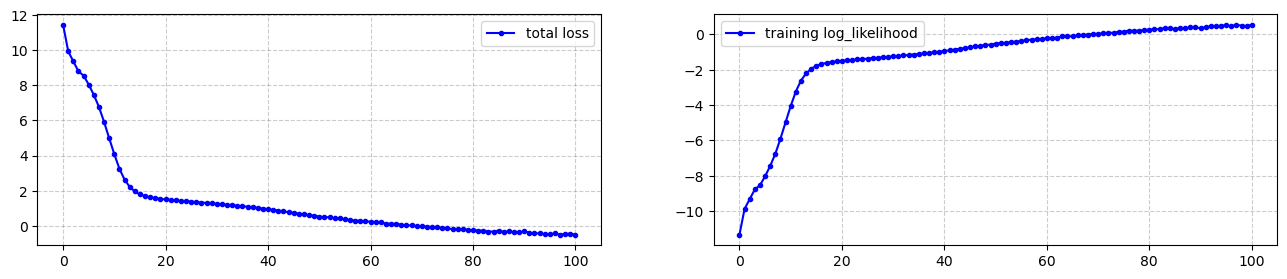

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCVAE(n_dim = 20, n_hid1 = 10, n_hid2 = 20, n_seq = 4).to(device)
model.train(data)

In [7]:
ts_data = np.random.normal(0, 1, size = (200, )).tolist() + np.random.normal(0, 4, size = (200, )).tolist()
anomalies = model.anomaly(ts_data)

training: 100%|██████████| 380/380 [00:00<00:00, 443.35it/s]


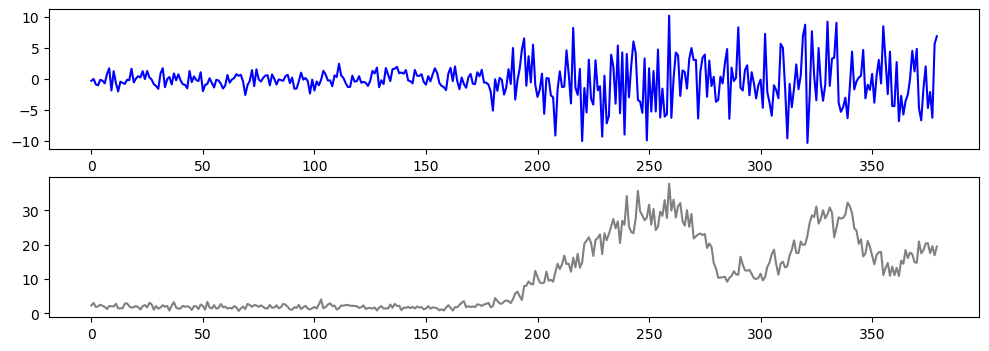

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (12, 4))
ax[0].plot(ts_data[-len(anomalies):], color = "blue")
ax[1].plot(anomalies, color = "gray")
plt.show()